In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint

In [26]:
# from paper

x_l = 5            # meter (Total length of small intestine and large intestine)
x_s = 3.5          # meter  (5 - 1.5 = 3.5 length of small intestine)
r_s = 1.25         # centimeter
r_l = 2.5          # centimeter
a_s = 0.65         # constant
a_l = 1.0          # constant
Q_s = 3            # mL/min
Q_l = 5            # mL/min
m   = 100          # milligram (dose)

# patient weight
w  = 70            # Kg
Vd = 1             # ranges (0.8–1.2)  # L / kg

# find flow velocity
v_s = Q_s / (np.pi * r_s**2)  # 
v_l = Q_l / (np.pi * r_l**2)  # 

# define carbamazepine drug spread out time scale tou
max_con = 0.5          # 
tou     = 2           # hrs  

# value to ka and ke which depends upon patients
ka = 0.5               # constant
ke = np.log(2) / 20     # constant

print(ke)

0.03465735902799726


Equation derived after solving analytically<br>
Solving the <br> 
$A(t) = k_{a} \int_{0}^{L}dx a(x) J(t - \dfrac{x}{v(x)}) e^{-k_a \int_{0}^{x}dx^{\prime} \dfrac{a(x^{\prime})}{v(x^{\prime})}}$<br>
let $Y = e^{-k_a \int_{0}^{x}dx^{\prime} \dfrac{a(x^{\prime})}{v(x^{\prime})}}$ <br>
Solving Y we get, <br>


$Y = e^{-k_a [\int_{0}^{x_s}dx^{\prime} \dfrac{a(x^{\prime})}{v(x^{\prime})} + \int_{x_s}^{x_l}dx^{\prime} \dfrac{a(x^{\prime})}{v(x^{\prime})}]}$

$ Y = e^{-k_a [\dfrac{x_s a_s}{v_s} + \dfrac{(x_l - x_s) a_l}{v_l}]}$  $a(x^{\prime}) = \begin{cases}
    a_s, 0 \le x^{\prime} \le x_s \\
    a_l, x_s \le x^{\prime} \le x_l
  \end{cases} $ $v(x) = \begin{cases}
    v_s, 0 \le x^{\prime} \le x_s \\
    v_l, x_s \le x^{\prime} \le x_l
  \end{cases} $<br>
  
Now, Y is independent of x <br>
 
$A(t) = k_{a} \int_{0}^{L}dx a(x) J(t - \dfrac{x}{v(x)}) Y$

$A(t) = ka.Y [\int_{0}^{x_s} dx a(x) J(t - \dfrac{x}{v(x)}) + \int_{x_s}^{x_l} dx a(x) J(t - \dfrac{x}{v(x)})]$

$A(t) = ka.Y [x_s a_s J(t - \dfrac{x_s}{v_s}) + (x_l - x_s) a_l J(t - \dfrac{x_l}{v_l})]$

$A(t) = k_ae^{-k_a\dfrac{x_sa_s}{v_s} + \dfrac{(x_l - x_s)}{v_l}}[x_sa_sJ(t - \dfrac{x_s}{v_s})+(x_l - x_s)a_lJ(t - \dfrac{x_l}{v_l})]$ <br>
$J(t) = \dfrac{m S(t)}{v(x=0)}$

In [27]:
# Define saw tooth funnction
def drug_spread_out(t, x):
    t = t - x

    if (t >= 0) and (t < tou /2):
        return (2 / tou**2)*t
    
    elif ((tou/2) < t) and (t < tou):
        return (2 / tou**2)*(tou - t)
    
    else:
        return 0
    
# solving equation for small_intestine
def small_intestine(t):
    x = (x_s / v_s)
    J = m*drug_spread_out(t, x) / v_s
    
    return (J*x_s*a_s)

# solving equation for large intestine
def large_intestine(t):
    x = (x_l / v_l)
    J = m*drug_spread_out(t, x) / v_s
    
    return ((x_l - x_s)*a_l*J)

# define ordinary differential equation
def model(b, t):
    A_t  =  ka*np.exp(-ka*(x_s*a_s/v_s + (x_l - x_s)*a_l / v_l))*(small_intestine(t) + large_intestine(t))
    dbdt = 1 / (w * Vd) * (A_t) - ke*b
    
    return dbdt

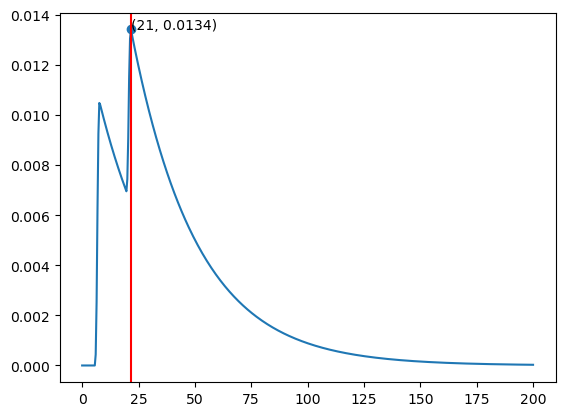

In [28]:
b = 0
t = np.linspace(0, 200, 500)


# solve the ODE equation
sol = odeint(model, b, t)

fig, ax = plt.subplots()

    
# plot results
ax.plot(t, sol)

max_peak_ind  = np.argmax(sol)
max_peak_time = t[max_peak_ind]

ax.axvline(x = max_peak_time, color = 'r', label = 'axvline - full height')

    
# ax.xlabel('time(hr)')
# ax.ylabel('$b(\dfrac{kg}{m^{3}})$')
ax.scatter(np.array([t[max_peak_ind]]), np.array([sol[max_peak_ind]]))
ax.annotate((int(t[max_peak_ind]), round(sol[max_peak_ind][0], 4)), (t[max_peak_ind], sol[max_peak_ind]))
    
plt.show()

Working on Sawtooth wave which repeats after 24 hrs

In [10]:
#perioid after 24 hrs
pd_time = 24
def find_sawtooth_wave(t, x):
#     J = 0
    pd_ind = int(t // pd_time)
    t      = t - pd_ind * pd_time
    J      = m*drug_spread_out(t, x)
    return J

In [11]:
doeses  = [100, 100]
pd_time = 24

# solving equation for small_intestine
def small_intestine(t):
    x = (x_s / v_s)
    J = m*find_sawtooth_wave(t, x) / v_s
    
    return (J*x_s*a_s)

# solving equation for large intestine
def large_intestine(t):
    x = (x_l / v_l)
    J = m*find_sawtooth_wave(t, x) / v_s
    
    return ((x_l - x_s)*a_l*J)

# define ordinary differential equation
def model(b, t):
    A_t  =  ka*np.exp(-ka*(x_s*a_s/v_s + (x_l - x_s)*a_l / v_l))*(small_intestine(t) + large_intestine(t))
    dbdt = 1 / (w * Vd) * (A_t) - ke*b
    
    return dbdt


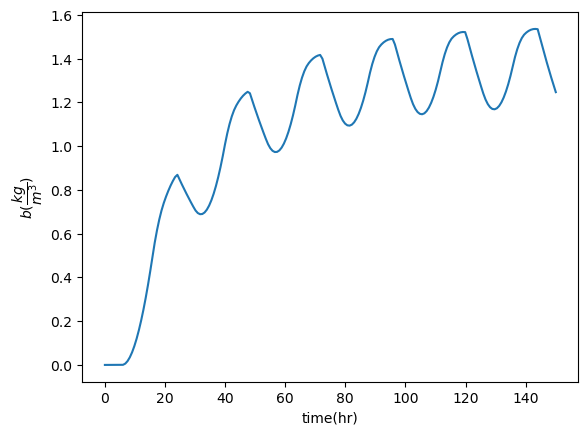

In [12]:
%matplotlib inline
b = 0
t = np.linspace(0, 150, 200)

# solve the ODE equation
sol = odeint(model, b, t)

# plot results
plt.plot(t, sol)
plt.xlabel('time(hr)')
plt.ylabel('$b(\dfrac{kg}{m^{3}})$')
plt.show()

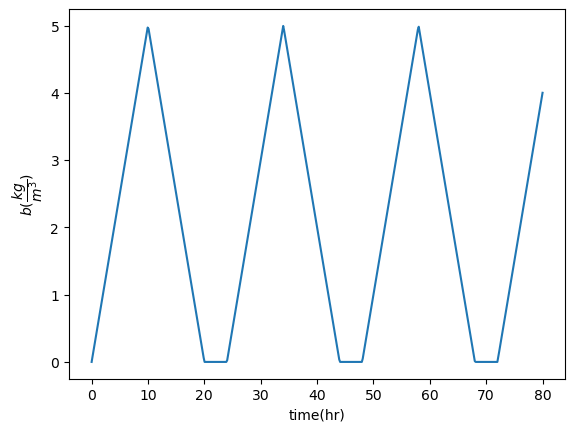

In [75]:
#perioid after 24 hrs

# def find_sawtooth_wave(x, t):
#     J = 0
#     for pd, m in enumerate(doeses):
#         t = t - pd * pd_time
#         print('t', t)
#         J += m*drug_spread_out(t, x)
#     return J

t = np.linspace(0, 80, 500)
x = 0

# x = 0
sol = [find_sawtooth_wave(x, i) for i in t]

# plot results
plt.plot(t, sol)
plt.xlabel('time(hr)')
plt.ylabel('$b(\dfrac{kg}{m^{3}})$')
plt.show()


For different value of tou

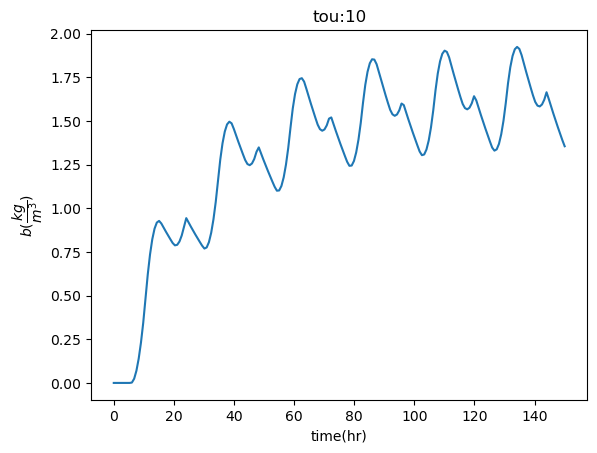

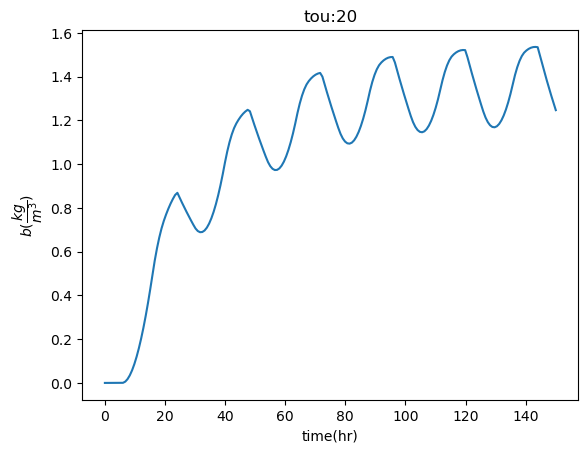

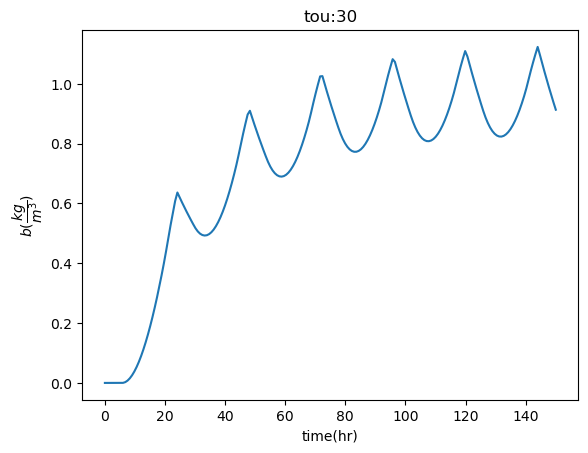

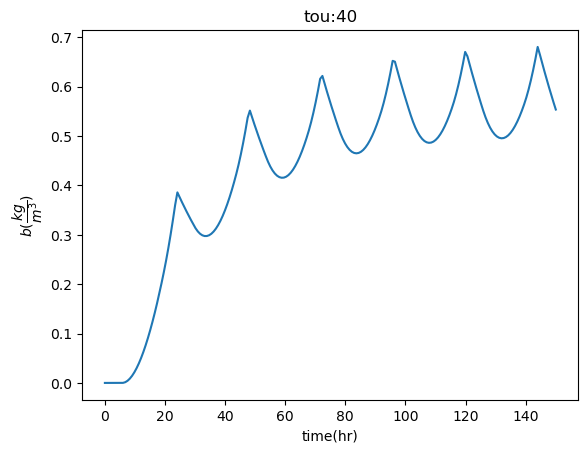

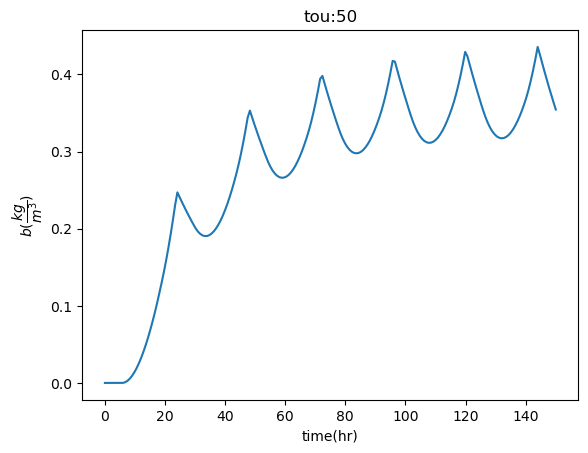

In [20]:
%matplotlib inline
b = 0
t = np.linspace(0, 150, 200)

for tt in [10, 20, 30, 40, 50]: 
    tou = tt
    
    b = 0
    t = np.linspace(0, 150, 200)
    
    # solve the ODE equation
    sol = odeint(model, b, t)

    # plot results
    plt.plot(t, sol)
    plt.xlabel('time(hr)')
    plt.ylabel('$b(\dfrac{kg}{m^{3}})$')
    plt.title(f'tou:{tou}')
    plt.show()

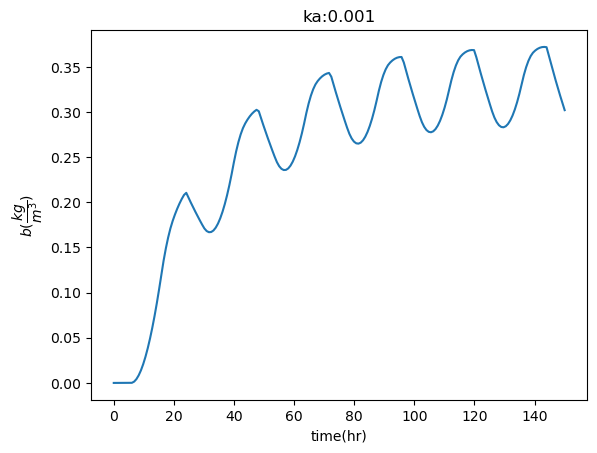

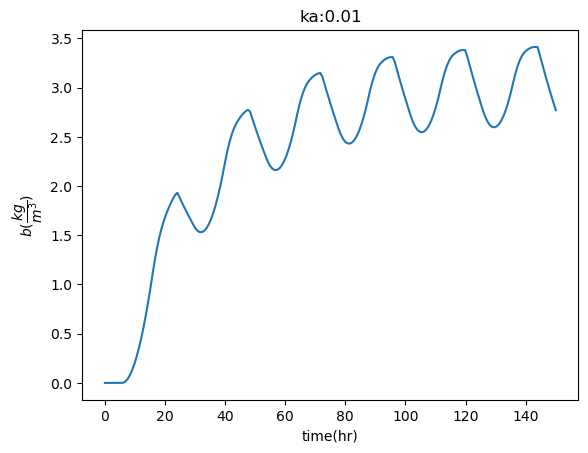

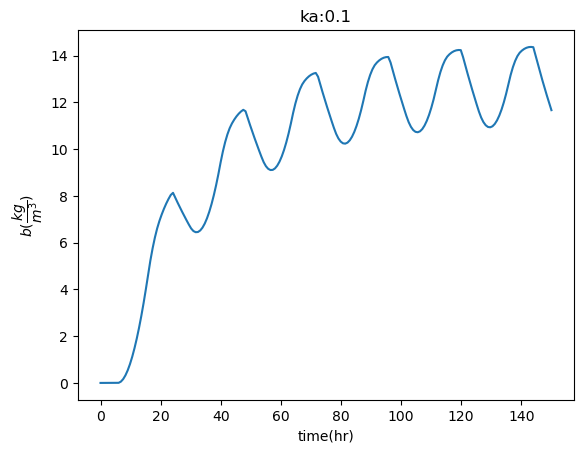

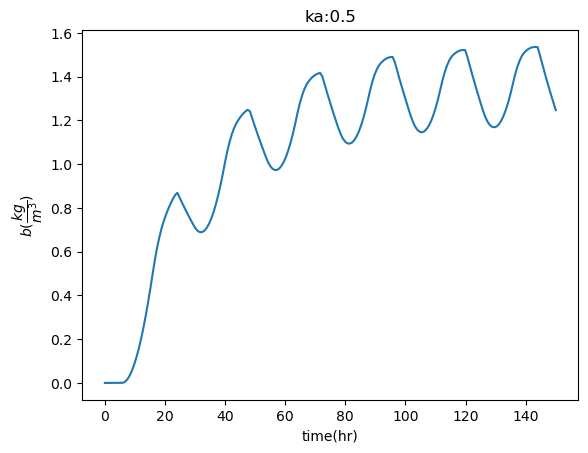

In [22]:
%matplotlib inline
b = 0
t = np.linspace(0, 150, 200)

for tt in [0.001, 0.01, 0.1, 0.5]: 
    global ka
    ka = tt
    
    b = 0
    t = np.linspace(0, 150, 200)
    
    # solve the ODE equation
    sol = odeint(model, b, t)

    # plot results
    plt.plot(t, sol)
    plt.xlabel('time(hr)')
    plt.ylabel('$b(\dfrac{kg}{m^{3}})$')
    plt.title(f'ka:{ka}')
    plt.show()